<a href="https://colab.research.google.com/github/jphall663/GWU_DNSC_6301_project/blob/main/DNSC_6301_Example_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### License

MIT License

Copyright (c) 2021 jphall@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

#### Pythons imports

In [1]:
from sklearn import tree                                  # sklearn tree model for decision trees
from sklearn.model_selection import train_test_split      # for partitioning data
from sklearn.model_selection import cross_val_score       # for cross validation
from sklearn.metrics import roc_auc_score, accuracy_score # to assess decision tree perforamce

# to upload local files
import io
from google.colab import files             

import numpy as np                                   # array, vector, matrix calculations
import pandas as pd                                  # dataFrame handling

from matplotlib import pyplot as plt                 # plotting
import seaborn as sns                                # slightly better plotting  

SEED = 12345                                         # ALWAYS use a random seed for better reproducibility

In [2]:
# print version information 
import sys
import sklearn
version = ".".join(map(str, sys.version_info[:3]))
print('Python version:', version)
print('sklearn version:', sklearn.__version__)

Python version: 3.7.13
sklearn version: 1.0.2


### Upload training data

In [3]:
 # special google collab command to upload a file from computer
uploaded = files.upload()

Saving credit_line_increase.csv to credit_line_increase.csv


In [4]:
type(uploaded) # what kind of Python object did we just create?

dict

In [5]:
uploaded.keys() # what is stored in that Python object?

dict_keys(['credit_line_increase.csv'])

In [6]:
# read uploaded data into a pandas dataframe
data = pd.read_csv(io.StringIO(uploaded['credit_line_increase.csv'].decode('utf-8')))

#### Data Dictionary

| Name | Modeling Role | Measurement Level| Description|
| ---- | ------------- | ---------------- | ---------- |
|**ID**| ID | int | unique row indentifier |
| **LIMIT_BAL** | input | float | amount of previously awarded credit |
| **SEX** | demographic information | int | 1 = male; 2 = female
| **RACE** | demographic information | int | 1 = hispanic; 2 = black; 3 = white; 4 = asian |
| **EDUCATION** | demographic information | int | 1 = graduate school; 2 = university; 3 = high school; 4 = others |
| **MARRIAGE** | demographic information | int | 1 = married; 2 = single; 3 = others |
| **AGE** | demographic information | int | age in years |
| **PAY_0, PAY_2 - PAY_6** | inputs | int | history of past payment; PAY_0 = the repayment status in September, 2005; PAY_2 = the repayment status in August, 2005; ...; PAY_6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above |
| **BILL_AMT1 - BILL_AMT6** | inputs | float | amount of bill statement; BILL_AMNT1 = amount of bill statement in September, 2005; BILL_AMT2 = amount of bill statement in August, 2005; ...; BILL_AMT6 = amount of bill statement in April, 2005 |
| **PAY_AMT1 - PAY_AMT6** | inputs | float | amount of previous payment; PAY_AMT1 = amount paid in September, 2005; PAY_AMT2 = amount paid in August, 2005; ...; PAY_AMT6 = amount paid in April, 2005 |
| **DELINQ_NEXT**| target | int | whether a customer's next payment is delinquent (late), 1 = late; 0 = on-time |

#### Basic Data Analysis

In [7]:
data.shape # (rows,columns)

(30000, 26)

In [8]:
data.columns # names of columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'RACE', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'DELINQ_NEXT'],
      dtype='object')

In [9]:
data.isnull().any() # check for missing values

ID             False
LIMIT_BAL      False
SEX            False
RACE           False
EDUCATION      False
MARRIAGE       False
AGE            False
PAY_0          False
PAY_2          False
PAY_3          False
PAY_4          False
PAY_5          False
PAY_6          False
BILL_AMT1      False
BILL_AMT2      False
BILL_AMT3      False
BILL_AMT4      False
BILL_AMT5      False
BILL_AMT6      False
PAY_AMT1       False
PAY_AMT2       False
PAY_AMT3       False
PAY_AMT4       False
PAY_AMT5       False
PAY_AMT6       False
DELINQ_NEXT    False
dtype: bool

In [10]:
data.describe() # basic descriptive statistics

ID       LIMIT_BAL           SEX          RACE     EDUCATION  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667      1.603733      2.721967      1.853133   
std     8660.398374   129747.661567      0.489129      1.094397      0.790349   
min        1.000000    10000.000000      1.000000      1.000000      0.000000   
25%     7500.750000    50000.000000      1.000000      2.000000      1.000000   
50%    15000.500000   140000.000000      2.000000      3.000000      2.000000   
75%    22500.250000   240000.000000      2.000000      4.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      4.000000      6.000000   

           MARRIAGE           AGE         PAY_0         PAY_2         PAY_3  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean       1.551867     35.485500     -0.016700     -0.133767     -0.166200   
std        0.521970      9.217904      1.123802      1.197186      1.196868   
min        0.000000     21.000000     -2.000000     -2.000000     -2.000000   
25%        1.000000     28.000000     -1.000000     -1.000000     -1.000000   
50%        2.000000     34.000000      0.000000      0.000000      0.000000   
75%        2.000000     41.000000      0.000000      0.000000      0.000000   
max        3.000000     79.000000      8.000000      8.000000      8.000000   

       ...      BILL_AMT4      BILL_AMT5      BILL_AMT6       PAY_AMT1  \
count  ...   30000.000000   30000.000000   30000.000000   30000.000000   
mean   ...   43262.948967   40311.400967   38871.760400    5663.580500   
std    ...   64332.856134   60797.155770   59554.107537   16563.280354   
min    ... -170000.000000  -81334.000000 -339603.000000       0.000000   
25%    ...    2326.750000    1763.000000    1256.000000    1000.000000   
50%    ...   19052.000000   18104.500000   17071.000000    2100.000000   
75%    ...   54506.000000   50190.500000   49198.250000    5006.000000   
max    ...  891586.000000  927171.000000  961664.000000  873552.000000   

           PAY_AMT2      PAY_AMT3       PAY_AMT4       PAY_AMT5  \
count  3.000000e+04   30000.00000   30000.000000   30000.000000   
mean   5.921163e+03    5225.68150    4826.076867    4799.387633   
std    2.304087e+04   17606.96147   15666.159744   15278.305679   
min    0.000000e+00       0.00000       0.000000       0.000000   
25%    8.330000e+02     390.00000     296.000000     252.500000   
50%    2.009000e+03    1800.00000    1500.000000    1500.000000   
75%    5.000000e+03    4505.00000    4013.250000    4031.500000   
max    1.684259e+06  896040.00000  621000.000000  426529.000000   

            PAY_AMT6   DELINQ_NEXT  
count   30000.000000  30000.000000  
mean     5215.502567      0.221200  
std     17777.465775      0.415062  
min         0.000000      0.000000  
25%       117.750000      0.000000  
50%      1500.000000      0.000000  
75%      4000.000000      0.000000  
max    528666.000000      1.000000  

[8 rows x 26 columns]

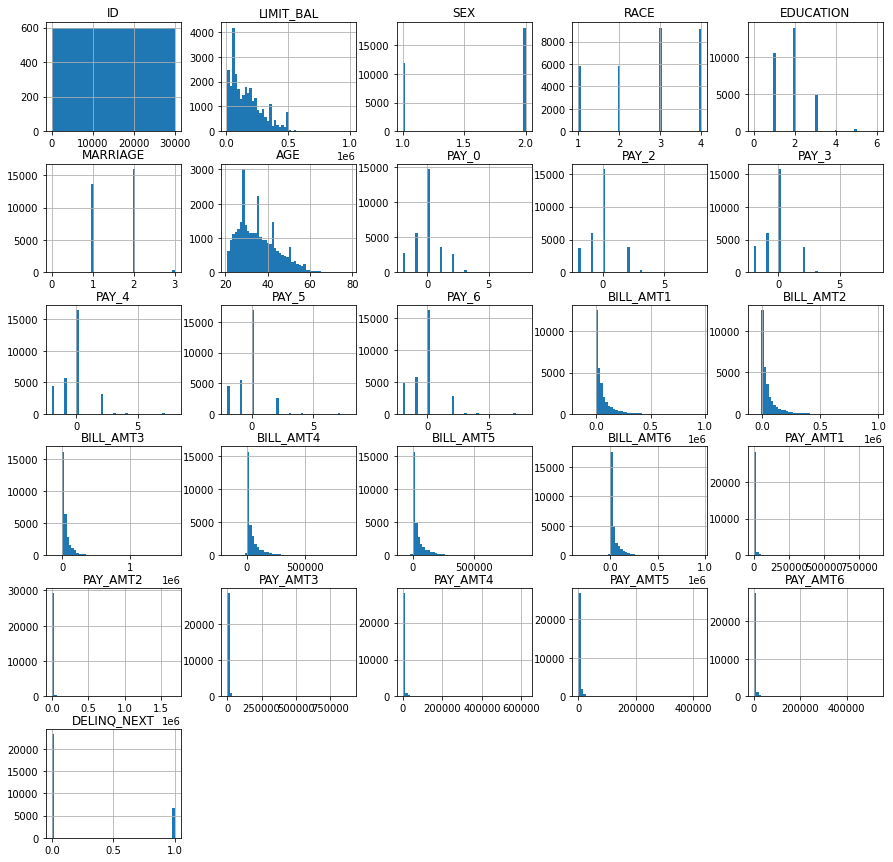

In [11]:
_ = data[data.columns].hist(bins=50, figsize=(15, 15)) # display histograms

In [12]:
# Pearson correlation matrix
corr = data.corr() 
corr

ID  LIMIT_BAL       SEX      RACE  EDUCATION  MARRIAGE  \
ID           1.000000   0.026179  0.018497 -0.000710   0.039177 -0.029079   
LIMIT_BAL    0.026179   1.000000  0.024755  0.044173  -0.219161 -0.108139   
SEX          0.018497   0.024755  1.000000  0.006149   0.014232 -0.031389   
RACE        -0.000710   0.044173  0.006149  1.000000  -0.012796  0.007010   
EDUCATION    0.039177  -0.219161  0.014232 -0.012796   1.000000 -0.143464   
MARRIAGE    -0.029079  -0.108139 -0.031389  0.007010  -0.143464  1.000000   
AGE          0.018678   0.144713 -0.090874  0.001284   0.175061 -0.414170   
PAY_0       -0.030575  -0.271214 -0.057643 -0.102487   0.105364  0.019917   
PAY_2       -0.011215  -0.296382 -0.070771 -0.082986   0.121566  0.024199   
PAY_3       -0.018494  -0.286123 -0.066096 -0.074547   0.114025  0.032688   
PAY_4       -0.002735  -0.267460 -0.060173 -0.072259   0.108793  0.033122   
PAY_5       -0.022199  -0.249411 -0.055064 -0.067316   0.097520  0.035629   
PAY_6       -0.020270  -0.235195 -0.044008 -0.054935   0.082316  0.034345   
BILL_AMT1    0.019389   0.285430 -0.033642  0.004232   0.023581 -0.023472   
BILL_AMT2    0.017982   0.278314 -0.031183  0.002459   0.018749 -0.021602   
BILL_AMT3    0.024354   0.283236 -0.024563  0.000543   0.013002 -0.024909   
BILL_AMT4    0.040351   0.293988 -0.021880  0.000376  -0.000451 -0.023344   
BILL_AMT5    0.016705   0.295562 -0.017005  0.002096  -0.007567 -0.025393   
BILL_AMT6    0.016730   0.290389 -0.016733  0.002756  -0.009099 -0.021207   
PAY_AMT1     0.009742   0.195236 -0.000242  0.030069  -0.037456 -0.005979   
PAY_AMT2     0.008406   0.178408 -0.001391  0.012681  -0.030038 -0.008093   
PAY_AMT3     0.039151   0.210167 -0.008597  0.021854  -0.039943 -0.003541   
PAY_AMT4     0.007793   0.203242 -0.002229  0.026047  -0.038218 -0.012659   
PAY_AMT5     0.000652   0.217202 -0.001667  0.022148  -0.040358 -0.001205   
PAY_AMT6     0.003000   0.219595 -0.002766  0.020259  -0.037200 -0.006641   
DELINQ_NEXT -0.013952  -0.153520 -0.039961 -0.303811   0.028006 -0.024339   

                  AGE     PAY_0     PAY_2     PAY_3  ...  BILL_AMT4  \
ID           0.018678 -0.030575 -0.011215 -0.018494  ...   0.040351   
LIMIT_BAL    0.144713 -0.271214 -0.296382 -0.286123  ...   0.293988   
SEX         -0.090874 -0.057643 -0.070771 -0.066096  ...  -0.021880   
RACE         0.001284 -0.102487 -0.082986 -0.074547  ...   0.000376   
EDUCATION    0.175061  0.105364  0.121566  0.114025  ...  -0.000451   
MARRIAGE    -0.414170  0.019917  0.024199  0.032688  ...  -0.023344   
AGE          1.000000 -0.039447 -0.050148 -0.053048  ...   0.051353   
PAY_0       -0.039447  1.000000  0.672164  0.574245  ...   0.179125   
PAY_2       -0.050148  0.672164  1.000000  0.766552  ...   0.222237   
PAY_3       -0.053048  0.574245  0.766552  1.000000  ...   0.227202   
PAY_4       -0.049722  0.538841  0.662067  0.777359  ...   0.245917   
PAY_5       -0.053826  0.509426  0.622780  0.686775  ...   0.271915   
PAY_6       -0.048773  0.474553  0.575501  0.632684  ...   0.266356   
BILL_AMT1    0.056239  0.187068  0.234887  0.208473  ...   0.860272   
BILL_AMT2    0.054283  0.189859  0.235257  0.237295  ...   0.892482   
BILL_AMT3    0.053710  0.179785  0.224146  0.227494  ...   0.923969   
BILL_AMT4    0.051353  0.179125  0.222237  0.227202  ...   1.000000   
BILL_AMT5    0.049345  0.180635  0.221348  0.225145  ...   0.940134   
BILL_AMT6    0.047613  0.176980  0.219403  0.222327  ...   0.900941   
PAY_AMT1     0.026147 -0.079269 -0.080701  0.001295  ...   0.233012   
PAY_AMT2     0.021785 -0.070101 -0.058990 -0.066793  ...   0.207564   
PAY_AMT3     0.029247 -0.070561 -0.055901 -0.053311  ...   0.300023   
PAY_AMT4     0.021379 -0.064005 -0.046858 -0.046067  ...   0.130191   
PAY_AMT5     0.022850 -0.058190 -0.037093 -0.035863  ...   0.160433   
PAY_AMT6     0.019478 -0.058673 -0.036500 -0.035861  ...   0.177637   
DELINQ_NEXT  0.013890  0.324794  0.263551  0.235253  ...  -0.010156   

             BILL_AMT

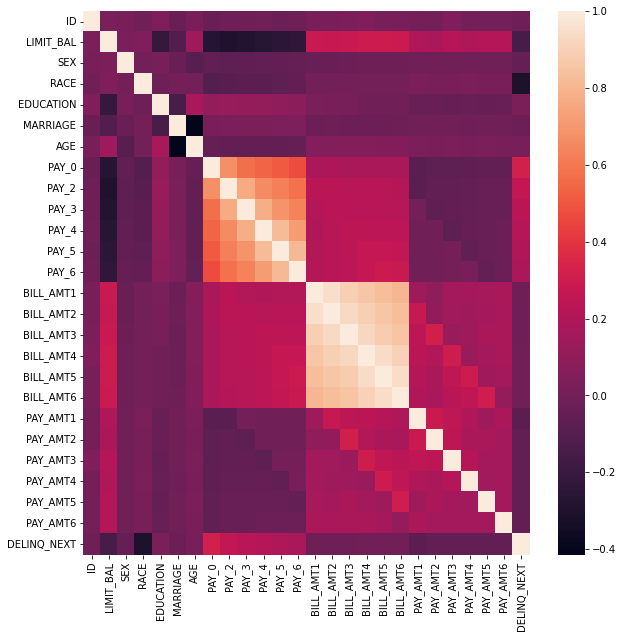

In [13]:
# correlation heatmap
plt.figure(figsize=(10, 10))
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

#### Train decision tree 

In [14]:
# assign basic modeling roles
# do not put demographic variables into a financial model!
y_name = 'DELINQ_NEXT'
X_names = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [16]:
# partition data for honest assessment
train_X, valid_test_X, train_y, valid_test_y = train_test_split(data[X_names], data[y_name], test_size=0.5, random_state=SEED) # split off training data
valid_X, test_X, valid_y, test_y = train_test_split(valid_test_X, valid_test_y, test_size=0.5, random_state=SEED) # split remainder into validation and test

# summarize 
print('Training data: %i rows and %i columns' % (train_X.shape[0], train_X.shape[1] + 1))
print('Validation data: %i rows and %i columns' % (valid_X.shape[0], valid_X.shape[1] + 1))
print('Testing data: %i rows and %i columns' % (test_X.shape[0], test_X.shape[1] + 1))

# housekeeping
del valid_test_X 
del valid_test_y

Training data: 15000 rows and 20 columns
Validation data: 7500 rows and 20 columns
Testing data: 7500 rows and 20 columns


In [17]:
# train decision tree 
# with validation-based early stopping

In [18]:
# plot tree depth vs. training and validation AUC
# using simple pandas plotting and matplotlib



In [19]:
# veiw same results as a table, using pandas iloc to remove first column of table


In [20]:
# plot the tree for human interpretation

In [21]:
# plot variable importances
# create pandas dataframe
# plot dataframe values


In [22]:
# score on test data for 
# final HONEST assessment
# this is not to see how well the model *did*!
# it's to get an assessment of how it *will do* on unseen data!


#### Function to create confusion matrices

In [23]:
# function for confusion matrices


#### Function to calculate AIR

In [24]:
# function for AIR


#### Bias testing

In [25]:
# add probabilities onto validation set
# note we need a probability cutoff to make a final lending decision


In [26]:
# calculate confusion matrices across race groups
# calculate confusion matrices at standard cutoff 0.15
# calculate AIR


In [27]:
# calculate confusion matrices across sex groups
# calculate confusion matrices at standard cutoff 0.15
# calculate AIR 


#### Bias Remediation

In [28]:
# function to calculate accuracy at a certain probability cutoff


In [29]:
# observe accuracy trend as cutoff increases
# the problem is: higher cutoff means lending more money, even if more accurate


In [30]:
# recalculate AIR and confusion matrices at different cutoff


In [31]:
# redo model search with new information
# train decision tree 
# with validation-based early stopping
# and AIR calculation!


In [32]:
# plot tree depth vs. training and validation AUC and AIR
# using simple pandas plotting and matplotlib

